In [1]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 📁 데이터 불러오기
df = pd.read_parquet('prepro_data.parquet')

In [ ]:
# 추가 학습 코드
# history_Line2_batch128 = Line2_model_batch128.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=50,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
#     initial_epoch=,         # 14번째까지 학습했다면 여기서 이어서 시작
#     callbacks=[early_stop, reduce_lr, checkpoint]
# )

# 1호선

## 1호선 데이터 불러오기

In [2]:
df1 = df[df['호선'] == 1].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df1['월'] = le.fit_transform(df1['월'])
df1['일'] = le.fit_transform(df1['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

<class 'pandas.core.frame.DataFrame'>
Index: 2732122 entries, 0 to 11364138
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: category(5), 

## 배치사이즈 128

# 드롭아웃 0.25


Epoch 1/300

17075/17076 [============================>.] - ETA: 0s - loss: 0.1797
Epoch 1: val_loss improved from inf to 0.23314, saving model to ./models\Dropout0.25_Line1.h5
17076/17076 [==============================] - 558s 32ms/step - loss: 0.1797 - val_loss: 0.2331 - lr: 0.0010
Epoch 2/300
    1/17076 [..............................] - ETA: 23:44 - loss: 0.0360

C:\Users\campus4D035\anaconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17075/17076 [============================>.] - ETA: 0s - loss: 0.0937
Epoch 2: val_loss improved from 0.23314 to 0.15234, saving model to ./models\Dropout0.25_Line1.h5
17076/17076 [==============================] - 612s 36ms/step - loss: 0.0937 - val_loss: 0.1523 - lr: 0.0010
Epoch 3/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0758
Epoch 3: val_loss improved from 0.15234 to 0.11074, saving model to ./models\Dropout0.25_Line1.h5
17076/17076 [==============================] - 668s 39ms/step - loss: 0.0758 - val_loss: 0.1107 - lr: 0.0010
Epoch 4/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0668
Epoch 4: val_loss improved from 0.11074 to 0.10950, saving model to ./models\Dropout0.25_Line1.h5
17076/17076 [==============================] - 642s 38ms/step - loss: 0.0668 - val_loss: 0.1095 - lr: 0.0010
Epoch 5/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0620
Epoch 5: val_loss did not improve from 0.10950
17076/17076 [===

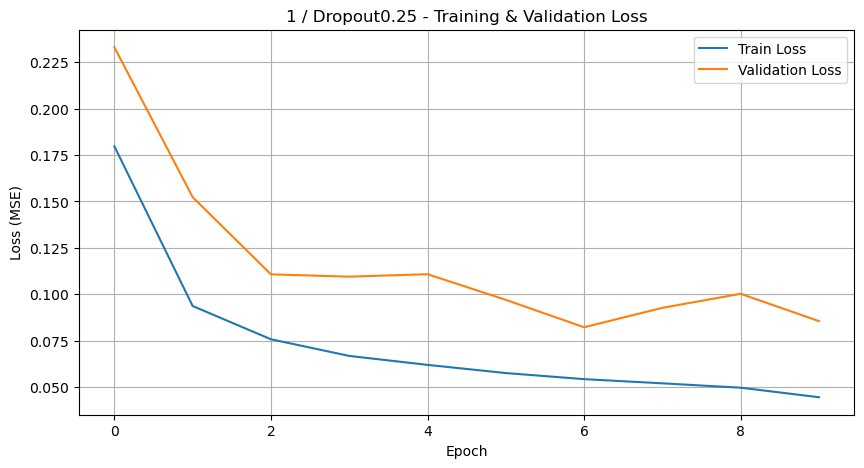

In [17]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
dropout = 0.25
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout025_Line1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout025_Line1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout025_Line1 = model_Dropout025_Line1.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout025_Line1.history['loss'], label='Train Loss')
plt.plot(History_Dropout025_Line1.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.30

Epoch 1/300
17076/17076 [==============================] - ETA: 0s - loss: 0.1867
Epoch 1: val_loss improved from inf to 0.15203, saving model to ./models\Dropout0.3_Line1.h5
17076/17076 [==============================] - 500s 29ms/step - loss: 0.1867 - val_loss: 0.1520 - lr: 0.0010
Epoch 2/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0959
Epoch 2: val_loss improved from 0.15203 to 0.13235, saving model to ./models\Dropout0.3_Line1.h5
17076/17076 [==============================] - 564s 33ms/step - loss: 0.0959 - val_loss: 0.1323 - lr: 0.0010
Epoch 3/300
17074/17076 [============================>.] - ETA: 0s - loss: 0.0773
Epoch 3: val_loss improved from 0.13235 to 0.12451, saving model to ./models\Dropout0.3_Line1.h5
17076/17076 [==============================] - 569s 33ms/step - loss: 0.0773 - val_loss: 0.1245 - lr: 0.0010
Epoch 4/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0693
Epoch 4: val_loss did not improve from 0.12451
17076/17076

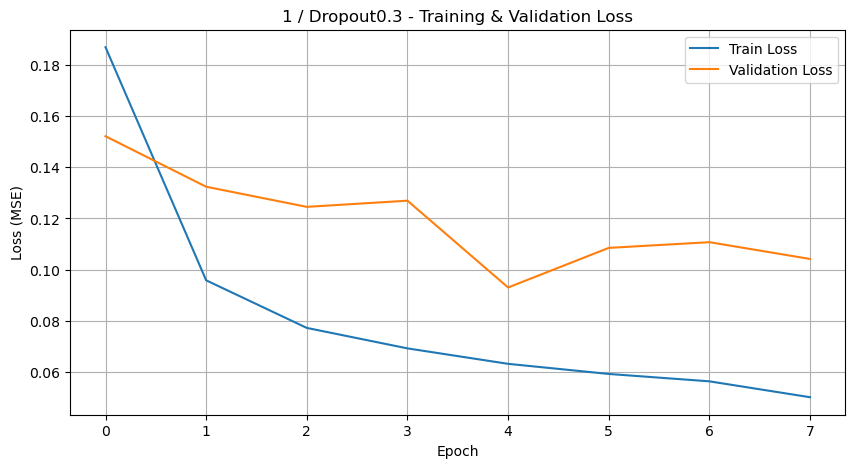

In [19]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
dropout = 0.30
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout030_Line1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout030_Line1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout030_Line1 = model_Dropout030_Line1.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout030_Line1.history['loss'], label='Train Loss')
plt.plot(History_Dropout030_Line1.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.35

Epoch 1/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.1932
Epoch 1: val_loss improved from inf to 0.14777, saving model to ./models\Dropout0.35_Line1.h5
17076/17076 [==============================] - 594s 35ms/step - loss: 0.1932 - val_loss: 0.1478 - lr: 0.0010
Epoch 2/300
17076/17076 [==============================] - ETA: 0s - loss: 0.1010
Epoch 2: val_loss did not improve from 0.14777
17076/17076 [==============================] - 587s 34ms/step - loss: 0.1010 - val_loss: 0.1717 - lr: 0.0010
Epoch 3/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0846
Epoch 3: val_loss improved from 0.14777 to 0.11173, saving model to ./models\Dropout0.35_Line1.h5
17076/17076 [==============================] - 589s 34ms/step - loss: 0.0846 - val_loss: 0.1117 - lr: 0.0010
Epoch 4/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.0747
Epoch 4: val_loss improved from 0.11173 to 0.09763, saving model to ./models\Dropout0.35_Line1.h5
17076/17

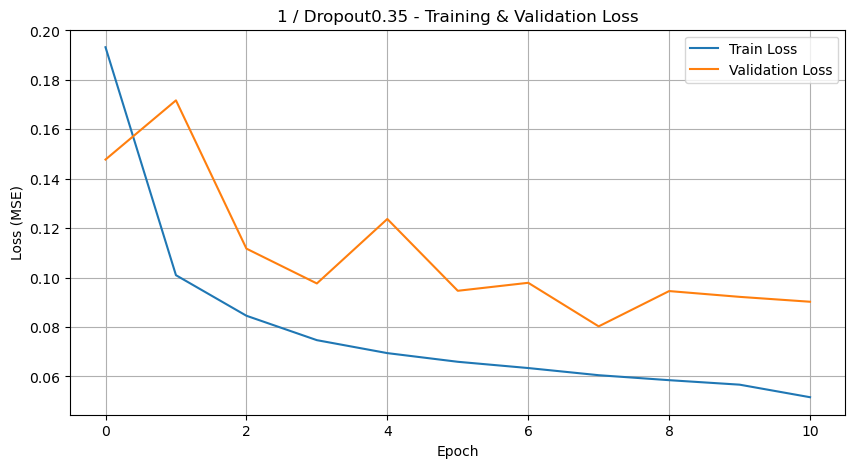

In [20]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
dropout = 0.35
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout035_Line1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout035_Line1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout035_Line1 = model_Dropout035_Line1.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout035_Line1.history['loss'], label='Train Loss')
plt.plot(History_Dropout035_Line1.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.40

Epoch 1/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.1956
Epoch 1: val_loss improved from inf to 0.20935, saving model to ./models\Dropout0.4_Line1.h5
17076/17076 [==============================] - 489s 29ms/step - loss: 0.1956 - val_loss: 0.2093 - lr: 0.0010
Epoch 2/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.1015
Epoch 2: val_loss improved from 0.20935 to 0.10900, saving model to ./models\Dropout0.4_Line1.h5
17076/17076 [==============================] - 520s 30ms/step - loss: 0.1015 - val_loss: 0.1090 - lr: 0.0010
Epoch 3/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0848
Epoch 3: val_loss did not improve from 0.10900
17076/17076 [==============================] - 516s 30ms/step - loss: 0.0848 - val_loss: 0.1309 - lr: 0.0010
Epoch 4/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.0760
Epoch 4: val_loss did not improve from 0.10900
17076/17076 [==============================] - 509s 30ms/step

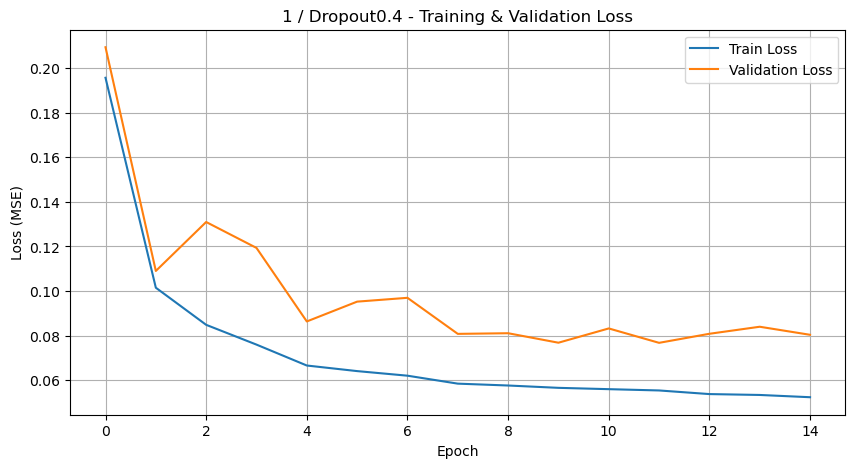

In [23]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
dropout = 0.40
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout040_Line1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout040_Line1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout040_Line1 = model_Dropout040_Line1.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout040_Line1.history['loss'], label='Train Loss')
plt.plot(History_Dropout040_Line1.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.45

Epoch 1/300
17076/17076 [==============================] - ETA: 0s - loss: 0.2009
Epoch 1: val_loss improved from inf to 0.26064, saving model to ./models\Dropout0.45_Line1.h5
17076/17076 [==============================] - 717s 42ms/step - loss: 0.2009 - val_loss: 0.2606 - lr: 0.0010
Epoch 2/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.1101
Epoch 2: val_loss improved from 0.26064 to 0.11840, saving model to ./models\Dropout0.45_Line1.h5
17076/17076 [==============================] - 709s 42ms/step - loss: 0.1101 - val_loss: 0.1184 - lr: 0.0010
Epoch 3/300
17075/17076 [============================>.] - ETA: 0s - loss: 0.0928
Epoch 3: val_loss did not improve from 0.11840
17076/17076 [==============================] - 707s 41ms/step - loss: 0.0928 - val_loss: 0.1205 - lr: 0.0010
Epoch 4/300
17076/17076 [==============================] - ETA: 0s - loss: 0.0842
Epoch 4: val_loss improved from 0.11840 to 0.10385, saving model to ./models\Dropout0.45_Line1.h5
17076/17

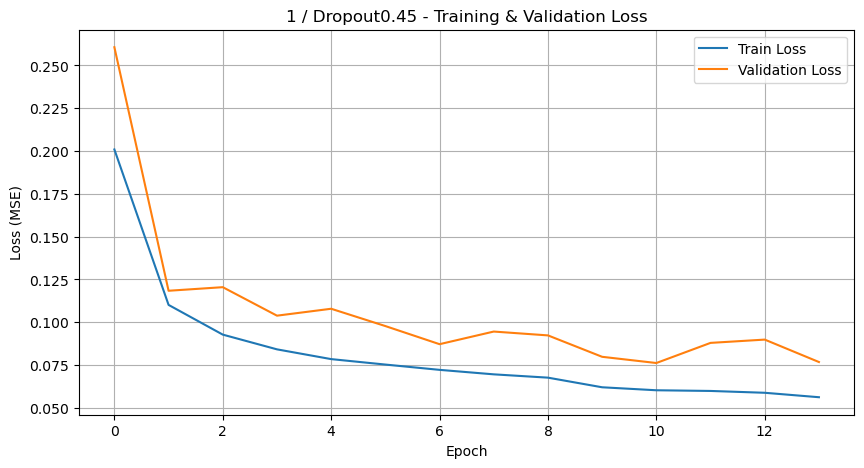

In [24]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
dropout = 0.45
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout045_Line1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout045_Line1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout045_Line1 = model_Dropout045_Line1.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout045_Line1.history['loss'], label='Train Loss')
plt.plot(History_Dropout045_Line1.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 1호선 모델 성능 테스트

In [25]:
plt.rcParams['font.family']='Malgun Gothic'

In [29]:
import os
os.listdir('./models')

['Dropout025_Line1.h5',
 'Dropout035_Line1.h5',
 'Dropout03_Line1.h5',
 'Dropout045_Line1.h5',
 'Dropout04_Line1.h5',
 'Line1_batch32.h5',
 'Line1_batch64.h5',
 'Line2_transfer.h5',
 'Line2_transfer_1024.h5']

In [30]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
Dropout25 = load_model('./models/Dropout025_Line1.h5', compile=False)
Dropout25.compile(loss='mse', optimizer=Adam(0.001))

Dropout30 = load_model('./models/Dropout03_Line1.h5', compile=False)
Dropout30.compile(loss='mse', optimizer=Adam(0.001))

Dropout35 = load_model('./models/Dropout035_Line1.h5', compile=False)
Dropout35.compile(loss='mse', optimizer=Adam(0.001))

Dropout40 = load_model('./models/Dropout04_Line1.h5', compile=False)
Dropout40.compile(loss='mse', optimizer=Adam(0.001))

Dropout45 = load_model('./models/Dropout045_Line1.h5', compile=False)
Dropout45.compile(loss='mse', optimizer=Adam(0.001))

# 검증셋에 대해 예측 수행
pred_scaled_25 = Dropout25.predict(val_gen)
pred_scaled_30 = Dropout30.predict(val_gen)
pred_scaled_35 = Dropout35.predict(val_gen)
pred_scaled_40 = Dropout40.predict(val_gen)
pred_scaled_45 = Dropout45.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_25 = ss.inverse_transform(pred_scaled_25)
pred_30 = ss.inverse_transform(pred_scaled_30)
pred_35 = ss.inverse_transform(pred_scaled_35)
pred_40 = ss.inverse_transform(pred_scaled_40)
pred_45 = ss.inverse_transform(pred_scaled_45)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

4269/4269 [==============================] - 74s 17ms/step


In [32]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE 계산 (squared=False는 MSE 계산에서만 유효한 인자임)
rmse_1 = np.sqrt(mean_squared_error(true, pred_25))
r2_1 = r2_score(true, pred_25)

rmse_2 = np.sqrt(mean_squared_error(true, pred_30))
r2_2 = r2_score(true, pred_30)

rmse_3 = np.sqrt(mean_squared_error(true, pred_35))
r2_3 = r2_score(true, pred_35)

rmse_4 = np.sqrt(mean_squared_error(true, pred_40))
r2_4 = r2_score(true, pred_40)

rmse_5 = np.sqrt(mean_squared_error(true, pred_45))
r2_5 = r2_score(true, pred_45)
                          # R² Score

# 결과 출력
print('✅Line1 Dropout = 0.25')
print(f" 검증 RMSE: {rmse_1:.4f}")
print(f" R² Score: {r2_1:.4f}")
print()
print('✅Line1 Dropout = 0.30')
print(f" 검증 RMSE: {rmse_2:.4f}")
print(f" R² Score: {r2_2:.4f}")
print()
print('✅Line1 Dropout = 0.35')
print(f" 검증 RMSE: {rmse_3:.4f}")
print(f" R² Score: {r2_3:.4f}")
print()
print('✅Line1 Dropout = 0.40')
print(f" 검증 RMSE: {rmse_4:.4f}")
print(f" R² Score: {r2_4:.4f}")
print()
print('✅Line1 Dropout = 0.45')
print(f" 검증 RMSE: {rmse_5:.4f}")
print(f" R² Score: {r2_5:.4f}")
print()

✅Line1 Dropout = 0.25
 검증 RMSE: 5.3196
 R² Score: 0.9488

✅Line1 Dropout = 0.30
 검증 RMSE: 5.6594
 R² Score: 0.9420

✅Line1 Dropout = 0.35
 검증 RMSE: 5.2559
 R² Score: 0.9500

✅Line1 Dropout = 0.40
 검증 RMSE: 5.1395
 R² Score: 0.9522

✅Line1 Dropout = 0.45
 검증 RMSE: 5.1210
 R² Score: 0.9525



In [33]:
org_rmse = 4.8583
org_r2 = 0.9573

# 조건에 따라 출력
results = [
    ("✅Line1 Dropout = 0.25", rmse_1, r2_1),
    ("✅Line1 Dropout = 0.30", rmse_2, r2_2),
    ("✅Line1 Dropout = 0.35", rmse_3, r2_3),
    ("✅Line1 Dropout = 0.40", rmse_4, r2_4),
    ("✅Line1 Dropout = 0.45", rmse_5, r2_5),
]

for label, rmse, r2 in results:
    if (rmse < org_rmse) and (r2 > org_r2):
        print(label)
        print(f" 검증 RMSE: {rmse:.4f}")
        print(f" R² Score: {r2:.4f}")
        print()

# 2호선

## 2호선 데이터 불러오기

In [2]:
df1 = df[df['호선'] == 2].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df1['월'] = le.fit_transform(df1['월'])
df1['일'] = le.fit_transform(df1['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

<class 'pandas.core.frame.DataFrame'>
Index: 1868722 entries, 950460 to 12006245
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: category

# 드롭아웃 0.25

Epoch 1/300

23358/23359 [============================>.] - ETA: 0s - loss: 0.1546
Epoch 1: val_loss improved from inf to 0.10301, saving model to ./models\Dropout0.25_Line2.h5
23359/23359 [==============================] - 544s 23ms/step - loss: 0.1546 - val_loss: 0.1030 - lr: 0.0010
Epoch 2/300
    4/23359 [..............................] - ETA: 8:39 - loss: 0.0533 

C:\Users\campus4D035\anaconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23359/23359 [==============================] - ETA: 0s - loss: 0.0803
Epoch 2: val_loss improved from 0.10301 to 0.09881, saving model to ./models\Dropout0.25_Line2.h5
23359/23359 [==============================] - 678s 29ms/step - loss: 0.0803 - val_loss: 0.0988 - lr: 0.0010
Epoch 3/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0666
Epoch 3: val_loss improved from 0.09881 to 0.07812, saving model to ./models\Dropout0.25_Line2.h5
23359/23359 [==============================] - 606s 26ms/step - loss: 0.0666 - val_loss: 0.0781 - lr: 0.0010
Epoch 4/300
23358/23359 [============================>.] - ETA: 0s - loss: 0.0595
Epoch 4: val_loss improved from 0.07812 to 0.06806, saving model to ./models\Dropout0.25_Line2.h5
23359/23359 [==============================] - 597s 26ms/step - loss: 0.0595 - val_loss: 0.0681 - lr: 0.0010
Epoch 5/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0549
Epoch 5: val_loss improved from 0.06806 to 0.06645, saving mode

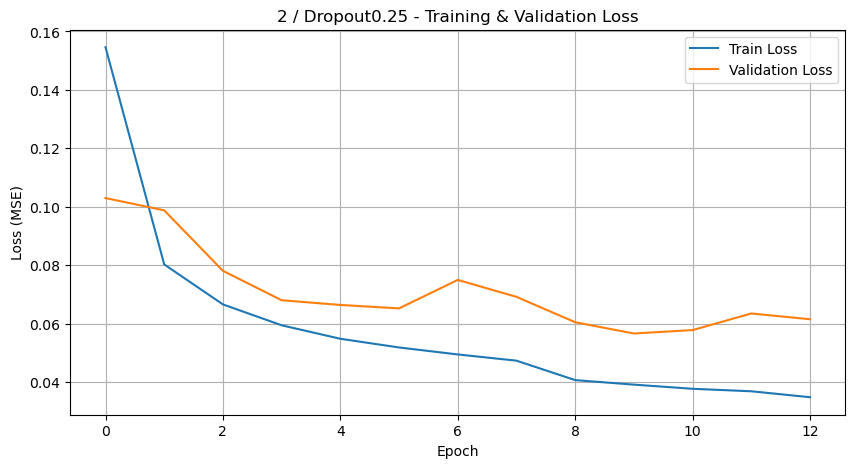

In [4]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
dropout = 0.25
batch_size = 64
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout025_Line2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout025_Line2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout025_Line2 = model_Dropout025_Line2.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout025_Line2.history['loss'], label='Train Loss')
plt.plot(History_Dropout025_Line2.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.30

Epoch 1/300
23358/23359 [============================>.] - ETA: 0s - loss: 0.1615
Epoch 1: val_loss improved from inf to 0.10176, saving model to ./models\Dropout0.3_Line2.h5
23359/23359 [==============================] - 577s 25ms/step - loss: 0.1615 - val_loss: 0.1018 - lr: 0.0010
Epoch 2/300
23359/23359 [==============================] - ETA: 0s - loss: 0.0858
Epoch 2: val_loss improved from 0.10176 to 0.07918, saving model to ./models\Dropout0.3_Line2.h5
23359/23359 [==============================] - 571s 24ms/step - loss: 0.0858 - val_loss: 0.0792 - lr: 0.0010
Epoch 3/300
23359/23359 [==============================] - ETA: 0s - loss: 0.0715
Epoch 3: val_loss improved from 0.07918 to 0.07396, saving model to ./models\Dropout0.3_Line2.h5
23359/23359 [==============================] - 574s 25ms/step - loss: 0.0715 - val_loss: 0.0740 - lr: 0.0010
Epoch 4/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0643
Epoch 4: val_loss improved from 0.07396 to 0.06976, saving

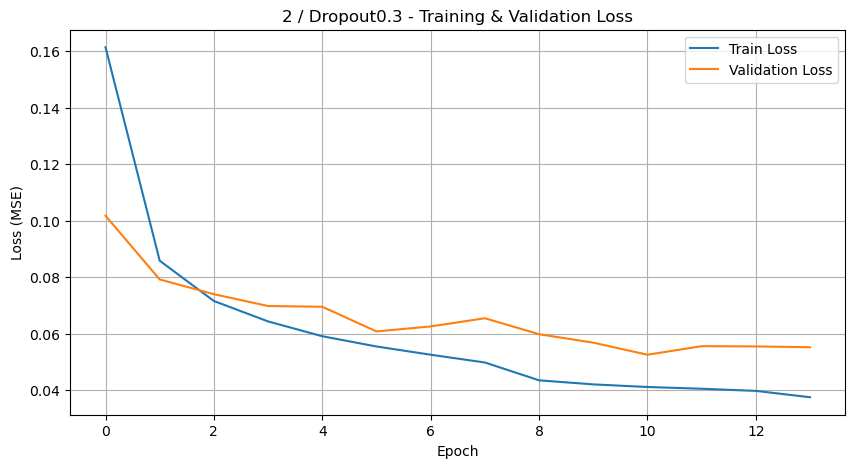

In [5]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
dropout = 0.30
batch_size = 64
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout030_Line2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout030_Line2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout030_Line2 = model_Dropout030_Line2.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout030_Line2.history['loss'], label='Train Loss')
plt.plot(History_Dropout030_Line2.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.35

Epoch 1/300
23358/23359 [============================>.] - ETA: 0s - loss: 0.1691
Epoch 1: val_loss improved from inf to 0.10461, saving model to ./models\Dropout0.35_Line2.h5
23359/23359 [==============================] - 580s 25ms/step - loss: 0.1691 - val_loss: 0.1046 - lr: 0.0010
Epoch 2/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0904
Epoch 2: val_loss improved from 0.10461 to 0.09717, saving model to ./models\Dropout0.35_Line2.h5
23359/23359 [==============================] - 571s 24ms/step - loss: 0.0904 - val_loss: 0.0972 - lr: 0.0010
Epoch 3/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0745
Epoch 3: val_loss improved from 0.09717 to 0.08284, saving model to ./models\Dropout0.35_Line2.h5
23359/23359 [==============================] - 576s 25ms/step - loss: 0.0745 - val_loss: 0.0828 - lr: 0.0010
Epoch 4/300
23359/23359 [==============================] - ETA: 0s - loss: 0.0678
Epoch 4: val_loss improved from 0.08284 to 0.07650, sav

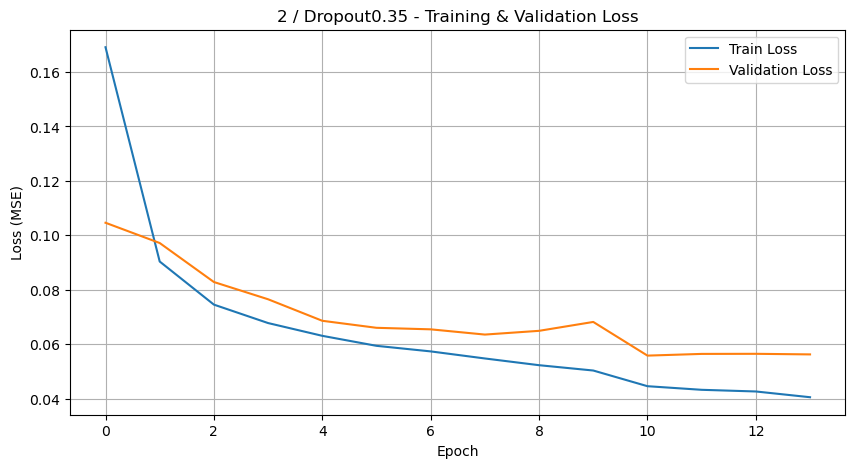

In [6]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
dropout = 0.35
batch_size = 64
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout035_Line2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout035_Line2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout035_Line2 = model_Dropout035_Line2.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout035_Line2.history['loss'], label='Train Loss')
plt.plot(History_Dropout035_Line2.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.40

Epoch 1/300
23358/23359 [============================>.] - ETA: 0s - loss: 0.1751
Epoch 1: val_loss improved from inf to 0.10781, saving model to ./models\Dropout0.4_Line2.h5
23359/23359 [==============================] - 580s 25ms/step - loss: 0.1751 - val_loss: 0.1078 - lr: 0.0010
Epoch 2/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0966
Epoch 2: val_loss improved from 0.10781 to 0.09327, saving model to ./models\Dropout0.4_Line2.h5
23359/23359 [==============================] - 578s 25ms/step - loss: 0.0966 - val_loss: 0.0933 - lr: 0.0010
Epoch 3/300
23358/23359 [============================>.] - ETA: 0s - loss: 0.0808
Epoch 3: val_loss improved from 0.09327 to 0.09116, saving model to ./models\Dropout0.4_Line2.h5
23359/23359 [==============================] - 530s 23ms/step - loss: 0.0808 - val_loss: 0.0912 - lr: 0.0010
Epoch 4/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0730
Epoch 4: val_loss improved from 0.09116 to 0.08299, saving

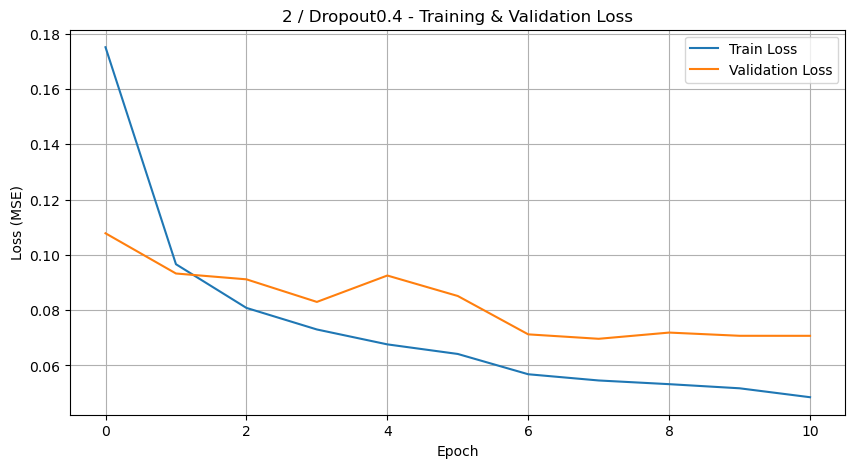

In [7]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
dropout = 0.40
batch_size = 64
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout040_Line2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout040_Line2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout040_Line2 = model_Dropout040_Line2.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout040_Line2.history['loss'], label='Train Loss')
plt.plot(History_Dropout040_Line2.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.45

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
dropout = 0.45
batch_size = 64
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout045_Line2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout045_Line2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout045_Line2 = model_Dropout045_Line2.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout045_Line2.history['loss'], label='Train Loss')
plt.plot(History_Dropout045_Line2.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/300
23356/23359 [============================>.] - ETA: 0s - loss: 0.1845
Epoch 1: val_loss improved from inf to 0.11594, saving model to ./models\Dropout0.45_Line2.h5
23359/23359 [==============================] - 537s 23ms/step - loss: 0.1845 - val_loss: 0.1159 - lr: 0.0010
Epoch 2/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.1049
Epoch 2: val_loss improved from 0.11594 to 0.08742, saving model to ./models\Dropout0.45_Line2.h5
23359/23359 [==============================] - 482s 21ms/step - loss: 0.1048 - val_loss: 0.0874 - lr: 0.0010
Epoch 3/300
23357/23359 [============================>.] - ETA: 0s - loss: 0.0909
Epoch 3: val_loss improved from 0.08742 to 0.08574, saving model to ./models\Dropout0.45_Line2.h5
23359/23359 [==============================] - 458s 20ms/step - loss: 0.0909 - val_loss: 0.0857 - lr: 0.0010
Epoch 4/300
23356/23359 [============================>.] - ETA: 0s - loss: 0.0836
Epoch 4: val_loss improved from 0.08574 to 0.08363, sav

# 모델 성능 평가

## 2호선 모델 성능 테스트

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
Dropout25 = load_model('./models/Dropout0.25_Line2.h5', compile=False)
Dropout25.compile(loss='mse', optimizer=Adam(0.001))

Dropout30 = load_model('./models/Dropout0.3_Line2.h5', compile=False)
Dropout30.compile(loss='mse', optimizer=Adam(0.001))

Dropout35 = load_model('./models/Dropout0.35_Line2.h5', compile=False)
Dropout35.compile(loss='mse', optimizer=Adam(0.001))

Dropout40 = load_model('./models/Dropout0.4_Line2.h5', compile=False)
Dropout40.compile(loss='mse', optimizer=Adam(0.001))

Dropout45 = load_model('./models/Dropout0.45_Line2.h5', compile=False)
Dropout45.compile(loss='mse', optimizer=Adam(0.001))

# 검증셋에 대해 예측 수행
pred_scaled_25 = Dropout25.predict(val_gen)
pred_scaled_30 = Dropout30.predict(val_gen)
pred_scaled_35 = Dropout35.predict(val_gen)
pred_scaled_40 = Dropout40.predict(val_gen)
pred_scaled_45 = Dropout45.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_25 = ss.inverse_transform(pred_scaled_25)
pred_30 = ss.inverse_transform(pred_scaled_30)
pred_35 = ss.inverse_transform(pred_scaled_35)
pred_40 = ss.inverse_transform(pred_scaled_40)
pred_45 = ss.inverse_transform(pred_scaled_45)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE 계산 (squared=False는 MSE 계산에서만 유효한 인자임)
rmse_1 = np.sqrt(mean_squared_error(true, pred_25))
r2_1 = r2_score(true, pred_25)

rmse_2 = np.sqrt(mean_squared_error(true, pred_30))
r2_2 = r2_score(true, pred_30)

rmse_3 = np.sqrt(mean_squared_error(true, pred_35))
r2_3 = r2_score(true, pred_35)

rmse_4 = np.sqrt(mean_squared_error(true, pred_40))
r2_4 = r2_score(true, pred_40)

rmse_5 = np.sqrt(mean_squared_error(true, pred_45))
r2_5 = r2_score(true, pred_45)
                          # R² Score

# 결과 출력
print('✅Line1 Dropout = 0.25')
print(f" 검증 RMSE: {rmse_1:.4f}")
print(f" R² Score: {r2_1:.4f}")
print()
print('✅Line1 Dropout = 0.30')
print(f" 검증 RMSE: {rmse_2:.4f}")
print(f" R² Score: {r2_2:.4f}")
print()
print('✅Line1 Dropout = 0.35')
print(f" 검증 RMSE: {rmse_3:.4f}")
print(f" R² Score: {r2_3:.4f}")
print()
print('✅Line1 Dropout = 0.40')
print(f" 검증 RMSE: {rmse_4:.4f}")
print(f" R² Score: {r2_4:.4f}")
print()
print('✅Line1 Dropout = 0.45')
print(f" 검증 RMSE: {rmse_5:.4f}")
print(f" R² Score: {r2_5:.4f}")
print()

In [ ]:
org_rmse = 4.4308
org_r2 = 0.9650

# 조건에 따라 출력
results = [
    ("✅Line1 Dropout = 0.25", rmse_1, r2_1),
    ("✅Line1 Dropout = 0.30", rmse_2, r2_2),
    ("✅Line1 Dropout = 0.35", rmse_3, r2_3),
    ("✅Line1 Dropout = 0.40", rmse_4, r2_4),
    ("✅Line1 Dropout = 0.45", rmse_5, r2_5),
]

for label, rmse, r2 in results:
    if (rmse < org_rmse) and (r2 > org_r2):
        print(label)
        print(f" 검증 RMSE: {rmse:.4f}")
        print(f" R² Score: {r2:.4f}")
        print()

# 3호선

## 3호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 3].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df1['월'] = le.fit_transform(df1['월'])
df1['일'] = le.fit_transform(df1['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# 드롭아웃 0.25

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
dropout = 0.25
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout025_Line3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout025_Line3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout025_Line3 = model_Dropout025_Line3.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout025_Line3.history['loss'], label='Train Loss')
plt.plot(History_Dropout025_Line3.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.30

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
dropout = 0.30
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout030_Line3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout030_Line3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout030_Line3 = model_Dropout030_Line3.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout030_Line3.history['loss'], label='Train Loss')
plt.plot(History_Dropout030_Line3.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.35

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
dropout = 0.35
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout035_Line3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout035_Line3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout035_Line3 = model_Dropout035_Line3.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout035_Line3.history['loss'], label='Train Loss')
plt.plot(History_Dropout035_Line3.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.40

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
dropout = 0.40
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout040_Line3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout040_Line3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout040_Line3 = model_Dropout040_Line3.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout040_Line3.history['loss'], label='Train Loss')
plt.plot(History_Dropout040_Line3.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.45

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
dropout = 0.45
batch_size = 128
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout045_Lin3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout045_Lin3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout045_Lin3 = model_Dropout045_Lin3.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout045_Lin3.history['loss'], label='Train Loss')
plt.plot(History_Dropout045_Lin3.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 3호선 모델 성능 테스트

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
Dropout25 = load_model('./models/Dropout0.25_Line3.h5', compile=False)
Dropout25.compile(loss='mse', optimizer=Adam(0.001))

Dropout30 = load_model('./models/Dropout0.3_Line3.h5', compile=False)
Dropout30.compile(loss='mse', optimizer=Adam(0.001))

Dropout35 = load_model('./models/Dropout0.35_Line3.h5', compile=False)
Dropout35.compile(loss='mse', optimizer=Adam(0.001))

Dropout40 = load_model('./models/Dropout0.4_Line3.h5', compile=False)
Dropout40.compile(loss='mse', optimizer=Adam(0.001))

Dropout45 = load_model('./models/Dropout0.45_Line3.h5', compile=False)
Dropout45.compile(loss='mse', optimizer=Adam(0.001))

# 검증셋에 대해 예측 수행
pred_scaled_25 = Dropout25.predict(val_gen)
pred_scaled_30 = Dropout30.predict(val_gen)
pred_scaled_35 = Dropout35.predict(val_gen)
pred_scaled_40 = Dropout40.predict(val_gen)
pred_scaled_45 = Dropout45.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_25 = ss.inverse_transform(pred_scaled_25)
pred_30 = ss.inverse_transform(pred_scaled_30)
pred_35 = ss.inverse_transform(pred_scaled_35)
pred_40 = ss.inverse_transform(pred_scaled_40)
pred_45 = ss.inverse_transform(pred_scaled_45)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE 계산 (squared=False는 MSE 계산에서만 유효한 인자임)
rmse_1 = np.sqrt(mean_squared_error(true, pred_25))
r2_1 = r2_score(true, pred_25)

rmse_2 = np.sqrt(mean_squared_error(true, pred_30))
r2_2 = r2_score(true, pred_30)

rmse_3 = np.sqrt(mean_squared_error(true, pred_35))
r2_3 = r2_score(true, pred_35)

rmse_4 = np.sqrt(mean_squared_error(true, pred_40))
r2_4 = r2_score(true, pred_40)

rmse_5 = np.sqrt(mean_squared_error(true, pred_45))
r2_5 = r2_score(true, pred_45)
                          # R² Score

# 결과 출력
print('✅Line1 Dropout = 0.25')
print(f" 검증 RMSE: {rmse_1:.4f}")
print(f" R² Score: {r2_1:.4f}")
print()
print('✅Line1 Dropout = 0.30')
print(f" 검증 RMSE: {rmse_2:.4f}")
print(f" R² Score: {r2_2:.4f}")
print()
print('✅Line1 Dropout = 0.35')
print(f" 검증 RMSE: {rmse_3:.4f}")
print(f" R² Score: {r2_3:.4f}")
print()
print('✅Line1 Dropout = 0.40')
print(f" 검증 RMSE: {rmse_4:.4f}")
print(f" R² Score: {r2_4:.4f}")
print()
print('✅Line1 Dropout = 0.45')
print(f" 검증 RMSE: {rmse_5:.4f}")
print(f" R² Score: {r2_5:.4f}")
print()

In [ ]:
org_rmse = 3.1487
org_r2 = 0.9572

# 조건에 따라 출력
results = [
    ("✅Line1 Dropout = 0.25", rmse_1, r2_1),
    ("✅Line1 Dropout = 0.30", rmse_2, r2_2),
    ("✅Line1 Dropout = 0.35", rmse_3, r2_3),
    ("✅Line1 Dropout = 0.40", rmse_4, r2_4),
    ("✅Line1 Dropout = 0.45", rmse_5, r2_5),
]

for label, rmse, r2 in results:
    if (rmse < org_rmse) and (r2 > org_r2):
        print(label)
        print(f" 검증 RMSE: {rmse:.4f}")
        print(f" R² Score: {r2:.4f}")
        print()

# 4호선

In [ ]:
org_rmse = 0.8955
org_r2 = 8.2487
line = 4
batch_size = 128

## 4호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 4].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df1['월'] = le.fit_transform(df1['월'])
df1['일'] = le.fit_transform(df1['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# 드롭아웃 0.25

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

dropout = 0.25
line=4
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout025_Line4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout025_Line4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout025_Line4 = model_Dropout025_Line4.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout025_Line4.history['loss'], label='Train Loss')
plt.plot(History_Dropout025_Line4.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.30

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

dropout = 0.30
line=4
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout030_Lin4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout030_Lin4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout030_Lin4 = model_Dropout030_Lin4.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout030_Lin4.history['loss'], label='Train Loss')
plt.plot(History_Dropout030_Lin4.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.35

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

dropout = 0.35
line=4
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout035_Lin4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout035_Lin4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout035_Lin4 = model_Dropout035_Lin4.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout035_Lin4.history['loss'], label='Train Loss')
plt.plot(History_Dropout035_Lin4.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.40

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

dropout = 0.40
line=4
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout040_Lin4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout040_Lin4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout040_Lin4 = model_Dropout040_Lin4.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout040_Lin4.history['loss'], label='Train Loss')
plt.plot(History_Dropout040_Lin4.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 드롭아웃 0.45

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

dropout = 0.45
line=4
save_path = './models/Dropout{}_Line{}.h5'.format(dropout, line)
graph_title = f'{line} / Dropout{dropout} - Training & Validation Loss'

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_Dropout045_Lin4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(dropout),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(dropout),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_Dropout045_Lin4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
History_Dropout045_Lin4 = model_Dropout045_Lin4.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(History_Dropout045_Lin4.history['loss'], label='Train Loss')
plt.plot(History_Dropout045_Lin4.history['val_loss'], label='Validation Loss')
plt.title(graph_title)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 4호선 모델 성능 테스트

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
Dropout25 = load_model('./models/Dropout0.25_Line4.h5', compile=False)
Dropout25.compile(loss='mse', optimizer=Adam(0.001))

Dropout30 = load_model('./models/Dropout0.3_Lin4.h5', compile=False)
Dropout30.compile(loss='mse', optimizer=Adam(0.001))

Dropout35 = load_model('./models/Dropout0.35_Lin4.h5', compile=False)
Dropout35.compile(loss='mse', optimizer=Adam(0.001))

Dropout40 = load_model('./models/Dropout0.4_Lin4.h5', compile=False)
Dropout40.compile(loss='mse', optimizer=Adam(0.001))

Dropout45 = load_model('./models/Dropout0.45_Lin4.h5', compile=False)
Dropout45.compile(loss='mse', optimizer=Adam(0.001))

# 검증셋에 대해 예측 수행
pred_scaled_25 = Dropout25.predict(val_gen)
pred_scaled_30 = Dropout30.predict(val_gen)
pred_scaled_35 = Dropout35.predict(val_gen)
pred_scaled_40 = Dropout40.predict(val_gen)
pred_scaled_45 = Dropout45.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_25 = ss.inverse_transform(pred_scaled_25)
pred_30 = ss.inverse_transform(pred_scaled_30)
pred_35 = ss.inverse_transform(pred_scaled_35)
pred_40 = ss.inverse_transform(pred_scaled_40)
pred_45 = ss.inverse_transform(pred_scaled_45)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE 계산 (squared=False는 MSE 계산에서만 유효한 인자임)
rmse_1 = np.sqrt(mean_squared_error(true, pred_25))
r2_1 = r2_score(true, pred_25)

rmse_2 = np.sqrt(mean_squared_error(true, pred_30))
r2_2 = r2_score(true, pred_30)

rmse_3 = np.sqrt(mean_squared_error(true, pred_35))
r2_3 = r2_score(true, pred_35)

rmse_4 = np.sqrt(mean_squared_error(true, pred_40))
r2_4 = r2_score(true, pred_40)

rmse_5 = np.sqrt(mean_squared_error(true, pred_45))
r2_5 = r2_score(true, pred_45)
                          # R² Score

# 결과 출력
print('✅Line1 Dropout = 0.25')
print(f" 검증 RMSE: {rmse_1:.4f}")
print(f" R² Score: {r2_1:.4f}")
print()
print('✅Line1 Dropout = 0.30')
print(f" 검증 RMSE: {rmse_2:.4f}")
print(f" R² Score: {r2_2:.4f}")
print()
print('✅Line1 Dropout = 0.35')
print(f" 검증 RMSE: {rmse_3:.4f}")
print(f" R² Score: {r2_3:.4f}")
print()
print('✅Line1 Dropout = 0.40')
print(f" 검증 RMSE: {rmse_4:.4f}")
print(f" R² Score: {r2_4:.4f}")
print()
print('✅Line1 Dropout = 0.45')
print(f" 검증 RMSE: {rmse_5:.4f}")
print(f" R² Score: {r2_5:.4f}")
print()

In [ ]:
# 조건에 따라 출력
results = [
    ("✅Line1 Dropout = 0.25", rmse_1, r2_1),
    ("✅Line1 Dropout = 0.30", rmse_2, r2_2),
    ("✅Line1 Dropout = 0.35", rmse_3, r2_3),
    ("✅Line1 Dropout = 0.40", rmse_4, r2_4),
    ("✅Line1 Dropout = 0.45", rmse_5, r2_5),
]

for label, rmse, r2 in results:
    if (rmse < org_rmse) and (r2 > org_r2):
        print(label)
        print(f" 검증 RMSE: {rmse:.4f}")
        print(f" R² Score: {r2:.4f}")
        print()

# 뭐야

In [20]:
df1 = df[df['호선'] == 4].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df1['월'] = le.fit_transform(df1['월'])
df1['일'] = le.fit_transform(df1['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

<class 'pandas.core.frame.DataFrame'>
Index: 2067984 entries, 2268840 to 13397452
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: categor

In [21]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 32
save_path = '/content/drive/MyDrive/models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21


# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch32 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch32.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch32 = Line4_model_batch32.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop
                                                                              ,reduce_lr
                                                                            ,checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51697/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1902
Epoch 1: val_loss improved from inf to 0.20155, saving model to /content/drive/MyDrive/models/Line4_batch32.h5


51699/51699 ━━━━━━━━━━━━━━━━━━━━ 416s 8ms/step - loss: 0.1902 - val_loss: 0.2016 - learning_rate: 0.0010
Epoch 2/50
51695/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0585
Epoch 2: val_loss improved from 0.20155 to 0.13226, saving model to /content/drive/MyDrive/models/Line4_batch32.h5


51699/51699 ━━━━━━━━━━━━━━━━━━━━ 411s 8ms/step - loss: 0.0585 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 3/50
51697/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0486
Epoch 3: val_loss did not improve from 0.13226
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 414s 8ms/step - loss: 0.0486 - val_loss: 0.1438 - learning_rate: 0.0010
Epoch 4/50
51698/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0446
Epoch 4: val_loss improved from 0.13226 to 0.12195, saving model to /content/drive/MyDrive/models/Line4_batch32.h5


51699/51699 ━━━━━━━━━━━━━━━━━━━━ 418s 8ms/step - loss: 0.0446 - val_loss: 0.1219 - learning_rate: 0.0010
Epoch 5/50
51694/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403
Epoch 5: val_loss did not improve from 0.12195
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 415s 8ms/step - loss: 0.0403 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 6/50
51694/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0393
Epoch 6: val_loss did not improve from 0.12195
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 415s 8ms/step - loss: 0.0393 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 7/50
51697/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329
Epoch 7: val_loss did not improve from 0.12195
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 417s 8ms/step - loss: 0.0329 - val_loss: 0.1295 - learning_rate: 5.0000e-04


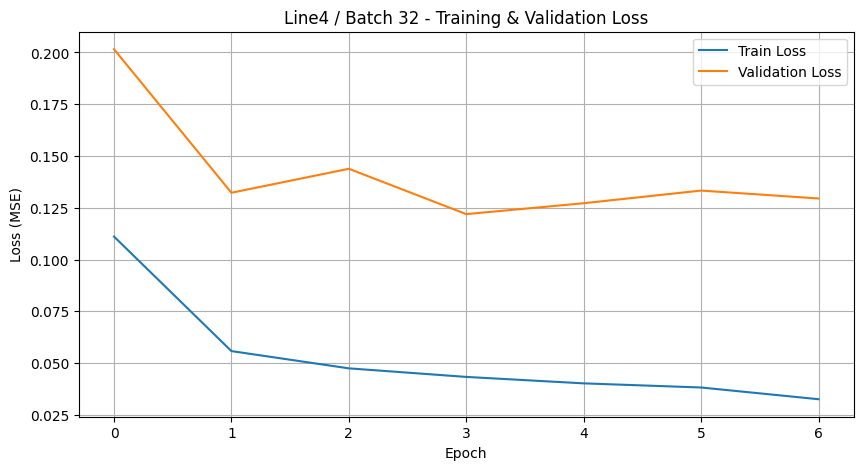

In [22]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch32.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch32.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 32 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 64
save_path = '/content/drive/MyDrive/models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch64 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch64.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch64 = Line4_model_batch64.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
25845/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2251
Epoch 1: val_loss improved from inf to 0.23577, saving model to /content/drive/MyDrive/models/Line4_batch64.h5


25850/25850 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - loss: 0.2251 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 2/50
25848/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0688
Epoch 2: val_loss improved from 0.23577 to 0.18351, saving model to /content/drive/MyDrive/models/Line4_batch64.h5


25850/25850 ━━━━━━━━━━━━━━━━━━━━ 224s 9ms/step - loss: 0.0688 - val_loss: 0.1835 - learning_rate: 0.0010
Epoch 3/50
25844/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0540
Epoch 3: val_loss improved from 0.18351 to 0.15612, saving model to /content/drive/MyDrive/models/Line4_batch64.h5


25850/25850 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - loss: 0.0540 - val_loss: 0.1561 - learning_rate: 0.0010
Epoch 4/50
25844/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0486
Epoch 4: val_loss improved from 0.15612 to 0.15218, saving model to /content/drive/MyDrive/models/Line4_batch64.h5


25850/25850 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - loss: 0.0486 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 5/50
25850/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0442
Epoch 5: val_loss improved from 0.15218 to 0.14537, saving model to /content/drive/MyDrive/models/Line4_batch64.h5


25850/25850 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - loss: 0.0442 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 6/50
25850/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0424
Epoch 6: val_loss did not improve from 0.14537
25850/25850 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - loss: 0.0424 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 7/50
25846/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0403
Epoch 7: val_loss did not improve from 0.14537
25850/25850 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - loss: 0.0403 - val_loss: 0.1552 - learning_rate: 0.0010
Epoch 8/50
25848/25850 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357
Epoch 8: val_loss did not improve from 0.14537
25850/25850 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - loss: 0.0357 - val_loss: 0.1587 - learning_rate: 5.0000e-04


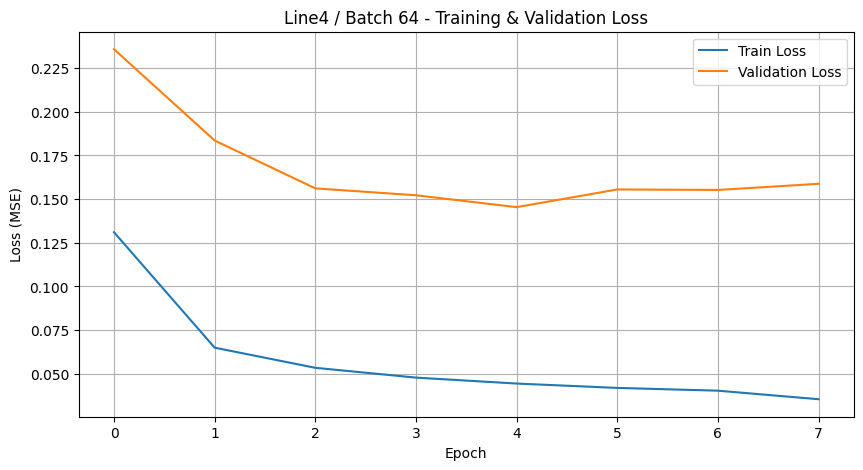

In [24]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch64.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch64.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 64 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 128
save_path = '/content/drive/MyDrive/models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch128 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch128.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch128 = Line4_model_batch128.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3034
Epoch 1: val_loss improved from inf to 0.21927, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.3034 - val_loss: 0.2193 - learning_rate: 0.0010
Epoch 2/50
12920/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0829
Epoch 2: val_loss improved from 0.21927 to 0.20539, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 0.0829 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 3/50
12924/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0678
Epoch 3: val_loss improved from 0.20539 to 0.13993, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0678 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 4/50
12923/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0576
Epoch 4: val_loss improved from 0.13993 to 0.12696, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0576 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 5/50
12924/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0515
Epoch 5: val_loss did not improve from 0.12696
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 0.0515 - val_loss: 0.1452 - learning_rate: 0.0010
Epoch 6/50
12921/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0475
Epoch 6: val_loss improved from 0.12696 to 0.12433, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 135s 10ms/step - loss: 0.0475 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 7/50
12922/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450
Epoch 7: val_loss did not improve from 0.12433
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 0.0450 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 8/50
12921/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0435
Epoch 8: val_loss improved from 0.12433 to 0.10581, saving model to /content/drive/MyDrive/models/Line4_batch128.h5


12925/12925 ━━━━━━━━━━━━━━━━━━━━ 135s 10ms/step - loss: 0.0435 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 9/50
12920/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396
Epoch 9: val_loss did not improve from 0.10581
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 0.0396 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 10/50
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0391
Epoch 10: val_loss did not improve from 0.10581
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0391 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 11/50
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0350
Epoch 11: val_loss did not improve from 0.10581
12925/12925 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 0.0350 - val_loss: 0.1220 - learning_rate: 5.0000e-04


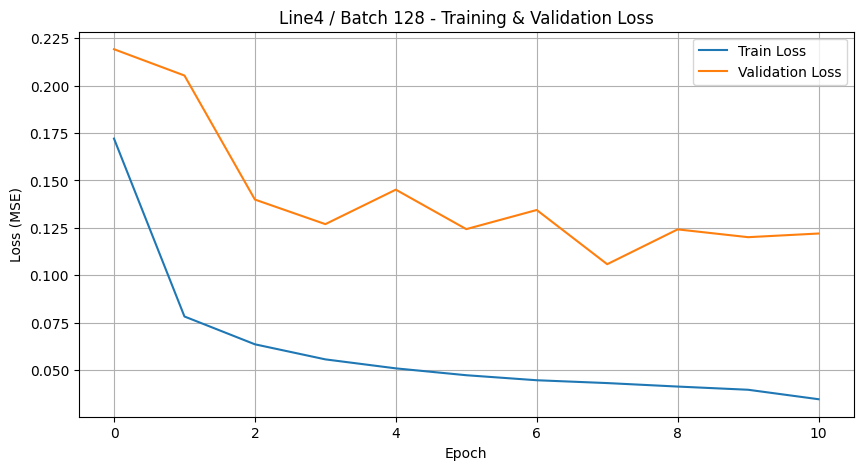

In [26]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch128.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch128.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 128 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 256
save_path = '/content/drive/MyDrive/models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch256 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch256.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch256 = Line4_model_batch256.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
6461/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3862
Epoch 1: val_loss improved from inf to 0.25168, saving model to /content/drive/MyDrive/models/Line4_batch256.h5


6463/6463 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.3861 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 2/50
6459/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1139
Epoch 2: val_loss did not improve from 0.25168
6463/6463 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.1139 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 3/50
6463/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0872
Epoch 3: val_loss improved from 0.25168 to 0.23313, saving model to /content/drive/MyDrive/models/Line4_batch256.h5


6463/6463 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.0872 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 4/50
6461/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0719
Epoch 4: val_loss improved from 0.23313 to 0.22085, saving model to /content/drive/MyDrive/models/Line4_batch256.h5


6463/6463 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - loss: 0.0719 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 5/50
6461/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0638
Epoch 5: val_loss improved from 0.22085 to 0.17139, saving model to /content/drive/MyDrive/models/Line4_batch256.h5


6463/6463 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.0638 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 6/50
6461/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0580
Epoch 6: val_loss did not improve from 0.17139
6463/6463 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - loss: 0.0580 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 7/50
6461/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0549
Epoch 7: val_loss did not improve from 0.17139
6463/6463 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.0549 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 8/50
6459/6463 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0463
Epoch 8: val_loss did not improve from 0.17139
6463/6463 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - loss: 0.0463 - val_loss: 0.1842 - learning_rate: 5.0000e-04


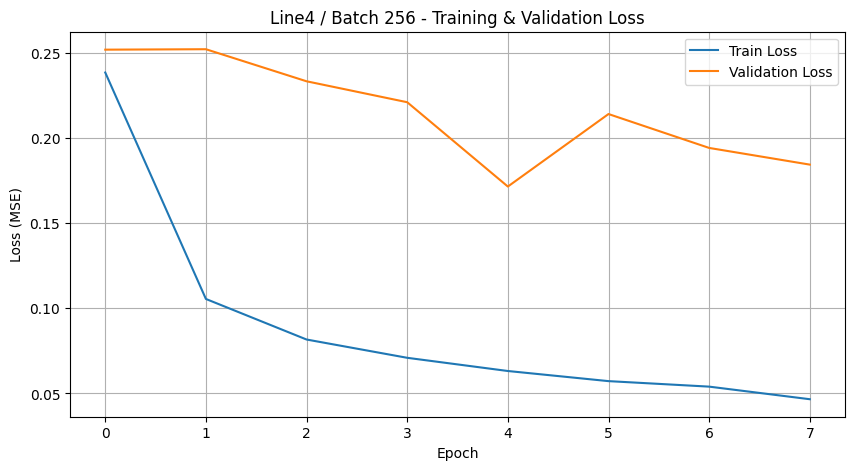

In [28]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch256.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch256.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 256 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('/content/drive/MyDrive/models/Line4_batch32.h5', compile=False)
loaded_model_32.compile(loss='mse', optimizer=Adam(0.001))

loaded_model_64 = load_model('/content/drive/MyDrive/models/Line4_batch64.h5', compile=False)
loaded_model_64.compile(loss='mse', optimizer=Adam(0.001))

loaded_model_128 = load_model('/content/drive/MyDrive/models/Line4_batch128.h5', compile=False)
loaded_model_128.compile(loss='mse', optimizer=Adam(0.001))

loaded_model_256 = load_model('/content/drive/MyDrive/models/Line4_batch256.h5', compile=False)
loaded_model_256.compile(loss='mse', optimizer=Adam(0.001))

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

1616/1616 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step


In [30]:
# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE 계산 (squared=False는 MSE 계산에서만 유효한 인자임)
rmse_32 = np.sqrt(mean_squared_error(true, pred_32))
r2_32 = r2_score(true, pred_32)

rmse_64 = np.sqrt(mean_squared_error(true, pred_64))
r2_64 = r2_score(true, pred_64)

rmse_128 = np.sqrt(mean_squared_error(true, pred_128))
r2_128 = r2_score(true, pred_128)

rmse_256 = np.sqrt(mean_squared_error(true, pred_256))
r2_256 = r2_score(true, pred_256)

# 결과 출력
print('✅Line4 batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅Line4 batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅Line4 batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅Line4 batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅Line4 batch size = 32
 검증 RMSE: 6.9579
 R² Score: 0.8795

✅Line4 batch size = 64
 검증 RMSE: 7.5969
 R² Score: 0.8564

✅Line4 batch size = 128
 검증 RMSE: 6.4813
 R² Score: 0.8955

✅Line4 batch size = 256
 검증 RMSE: 8.2487
 R² Score: 0.8307
